In [1]:
import keras
from keras import layers

# This is the size of our encoded representations
encoding_dim = 64  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# This is our input image
input_img = keras.Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(784, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)


In [2]:
# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)


In [3]:
# This is our encoded (32-dimensional) input
encoded_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

In [4]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [5]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

In [6]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [7]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
235/235 [==============================] - 7s 24ms/step - loss: 0.3462 - val_loss: 0.1642
Epoch 2/50
235/235 [==============================] - 2s 8ms/step - loss: 0.1537 - val_loss: 0.1263
Epoch 3/50
235/235 [==============================] - 2s 8ms/step - loss: 0.1226 - val_loss: 0.1090
Epoch 4/50
235/235 [==============================] - 2s 8ms/step - loss: 0.1069 - val_loss: 0.0983
Epoch 5/50
235/235 [==============================] - 2s 8ms/step - loss: 0.0974 - val_loss: 0.0910
Epoch 6/50
235/235 [==============================] - 2s 8ms/step - loss: 0.0907 - val_loss: 0.0858
Epoch 7/50
235/235 [==============================] - 2s 8ms/step - loss: 0.0856 - val_loss: 0.0820
Epoch 8/50
235/235 [==============================] - 2s 10ms/step - loss: 0.0822 - val_loss: 0.0795
Epoch 9/50
235/235 [==============================] - 2s 9ms/step - loss: 0.0797 - val_loss: 0.0776
Epoch 10/50
235/235 [==============================] - 2s 10ms/step - loss: 0.0781 - val_loss: 0.0

In [8]:
# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

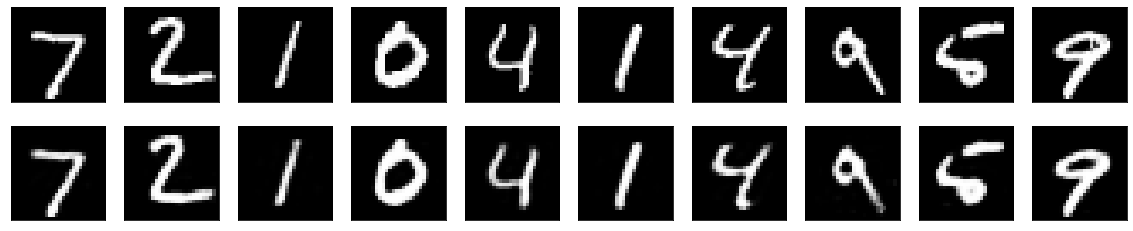

In [9]:
# Use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [10]:
import cv2

brad = cv2.imread('brad.jpg', cv2.IMREAD_GRAYSCALE)

In [11]:
brad.shape

(3508, 2480)

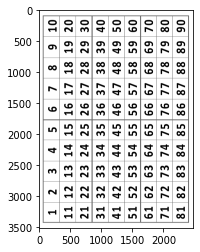

In [12]:
plt.imshow(brad)

In [13]:
def padding(array, xx, yy):
    """
    :param array: numpy array
    :param xx: desired height
    :param yy: desirex width
    :return: padded array
    """

    h = array.shape[0]
    w = array.shape[1]

    a = (xx - h) // 2
    aa = xx - a - h

    b = (yy - w) // 2
    bb = yy - b - w

    return np.pad(array, pad_width=((a, aa), (b, bb)), mode='constant')

In [14]:
padded_brad = 255 - padding(brad, ((brad.shape[0] + 28 - 1) // 28) * 28, ((brad.shape[1] + 28 - 1) // 28) * 28)

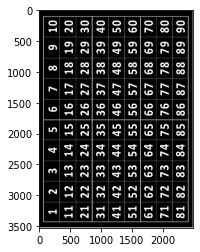

In [15]:
plt.imshow(padded_brad)

In [16]:
def blockshaped(arr, nrows, ncols):
    return arr.reshape(-1, nrows * ncols)

In [17]:
blocks_brad = blockshaped(padded_brad, 28, 28)
encoded_blocks = encoder.predict(blocks_brad)
decoded_blocks = decoder.predict(encoded_blocks)

In [18]:
print(blocks_brad.shape)
print(encoded_blocks.shape)
print(decoded_blocks.shape)

(11214, 784)
(11214, 64)
(11214, 784)


In [19]:
def unblockshaped(arr, h, w):
    return arr.reshape(h, w)

In [20]:
restored_brad = unblockshaped(decoded_blocks, padded_brad.shape[0], padded_brad.shape[1])

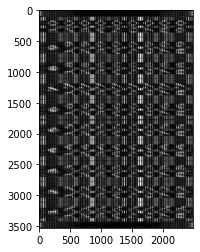

In [21]:
plt.imshow(restored_brad)

In [23]:
plt.imsave('restored.png', restored_brad)